In [1]:
import numpy as np
import pandas as pd
import cv2
from glob import glob
import os
import pathlib

import matplotlib.pyplot as plt
from tqdm import tqdm

## Img, Label 확인

In [2]:
img_dir = '../datasets/emart24/cls_data/normal_aug/'
result = []
idx = 0

label_list = [f for f in os.listdir(img_dir) if not f.startswith('.')]

for label in label_list:
    file_list = glob(os.path.join(img_dir,label,'*'))
    
    for file in file_list:
        result.append([idx, label, file])
        idx += 1
        
img_df = pd.DataFrame(result, columns=['idx','label','image_path'])
img_df

idx             label  \
0          0  fanta orange_pet   
1          1  fanta orange_pet   
2          2  fanta orange_pet   
3          3  fanta orange_pet   
4          4  fanta orange_pet   
...      ...               ...   
24027  24027        welchs_can   
24028  24028        welchs_can   
24029  24029        welchs_can   
24030  24030        welchs_can   
24031  24031        welchs_can   

                                              image_path  
0      ../datasets/emart24/cls_data/normal_aug/fanta ...  
1      ../datasets/emart24/cls_data/normal_aug/fanta ...  
2      ../datasets/emart24/cls_data/normal_aug/fanta ...  
3      ../datasets/emart24/cls_data/normal_aug/fanta ...  
4      ../datasets/emart24/cls_data/normal_aug/fanta ...  
...                                                  ...  
24027  ../datasets/emart24/cls_data/normal_aug/welchs...  
24028  ../datasets/emart24/cls_data/normal_aug/welchs...  
24029  ../datasets/emart24/cls_data/normal_aug/welchs...  
24030  ../datasets/emart24/cls_data/normal_aug/welchs...  
24031  ../datasets/emart24/cls_data/normal_aug/welchs...  

[24032 rows x 3 columns]

2% peach_pet        1014
2%_can               521
aloe_pet             989
bongbong_can         502
coca_can             991
coca_pet            1009
daily C_pet          987
demisoda_can         501
fanta orange_pet     976
fanta pine_pet       501
galbae_can           518
galbae_pet          1017
hwal_pet             504
jeju_pet             985
lemonade_pet         509
mango_can            508
mccol_pet            503
milkis_can           482
milkis_pet          1000
mogumogu_pet         504
morning_pet          507
oranC_can            498
peach_can            505
pepsi_can            506
pepsi_pet            978
pocari_can          1002
power_can            992
redbull_can          503
sol_can              502
sprite_can           502
sprite_pet           999
tejava_can           513
vilak_pet            499
vita500_pet          500
welchs_can           505
Name: label, dtype: int64

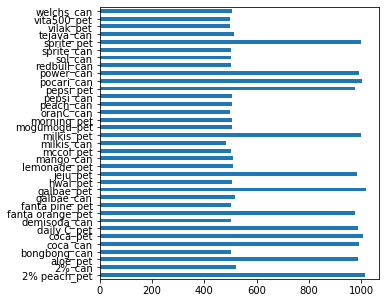

In [3]:
plt.figure(figsize=(5,5))
img_df['label'].value_counts().sort_index().plot.barh()

img_df['label'].value_counts().sort_index()

## Augmentation

In [4]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90, RandomGamma, VerticalFlip,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue, 
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose, Rotate, RandomContrast, RandomBrightness, RandomCrop, Resize, OpticalDistortion
)

In [42]:
# 음료 classification용

transforms = Compose([
        #Rotate(limit=30, p=0.5),
        #Rotate(limit=180, p=0.5),
        #RandomRotate90(p=1.0)
        #Transpose(p=1.0)
        Resize(248,248, p=1),     # resize 후 크롭
        RandomCrop(224,224, p=1),  # 위에꺼랑 세트
        
        OneOf([
        RandomContrast(p=1, limit=(-0.5,2)),   # -0.5 ~ 2 까지가 현장과 가장 비슷함  -- RandomBrightnessContrast
        RandomBrightness(p=1, limit=(-0.2,0.4)),
        RandomGamma(p=1, gamma_limit=(80,200)),
        ], p=0.6),
            
        OneOf([
            Rotate(limit=30, p=0.3),
            RandomRotate90(p=0.3),
            VerticalFlip(p=0.3)
        ], p=0.3),
    
        #MotionBlur(p=0.2),   # 움직일때 흔들리는 것 같은 이미지
        #ShiftScaleRotate(shift_limit=0.001, scale_limit=0.1, rotate_limit=30, p=0.3, border_mode=1),
        Resize(224,224, p=1),
        ],
        p=1)

In [64]:
transforms = Compose([

        Resize(248,248, p=0.5),     # resize 후 크롭
        RandomCrop(224,224, p=0.5),  # 위에꺼랑 세트
        
        OneOf([
        RandomContrast(p=1, limit=(-0.5,1.5)),   # -0.5 ~ 2 까지가 현장과 가장 비슷함  -- RandomBrightnessContrast
        RandomBrightness(p=1, limit=(-0.2,0.4)),
        RandomGamma(p=1, gamma_limit=(80,180)),
        ], p=0.6),
            
        OneOf([
            #Rotate(limit=30, p=0.3),
            #RandomRotate90(p=0.3),
            HorizontalFlip(p=1)
        ], p=1),
    
        MotionBlur(p=0.2),   # 움직일때 흔들리는 것 같은 이미지
        #ShiftScaleRotate(shift_limit=0.001, scale_limit=0.1, rotate_limit=30, p=0.3, border_mode=1),
        Resize(224,224, p=1),
        ],
        p=1)

Text(0.5, 1.0, 'transformed - (224, 224, 3)')

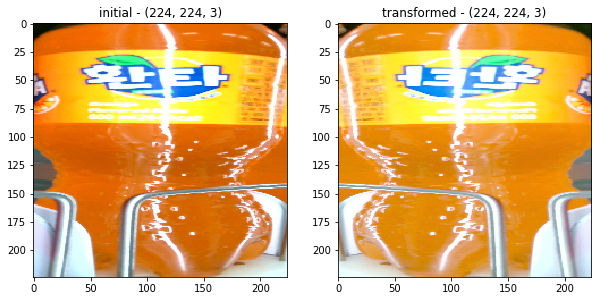

In [68]:
# augmentation option 확인

img = cv2.imread(img_df['image_path'][211])
img = cv2.resize(img,(224,224))
img = cv2.cvtColor(img, cv2.cv2.COLOR_BGR2RGB)
#img = img.reshape((224,224))
img.shape

img1 = transforms(image=img)['image']

f, ax = plt.subplots(1,2,figsize=(10,16))
ax[0].imshow(img)
ax[1].imshow(img1)

ax[0].set_title('initial - {}'.format(img.shape))
ax[1].set_title('transformed - {}'.format(img1.shape))

In [29]:
a = img_df.sample(n=5)['label']

In [103]:
img_df[img_df['label'] == 'power'].sample(n=1)['image_path'].iloc[0]

'../datasets/aug_test_copy/power/0.jpg'

In [69]:
TOTAL_IMG_COUNT = 1500

for label in tqdm(label_list):
    #print(label)
    counts = len(img_df[img_df['label'] == f'{label}'])

    while True:
        if counts < TOTAL_IMG_COUNT:
            img_path = img_df[img_df['label'] == f'{label}'].sample(n=1)['image_path'].iloc[0]
            img = cv2.imread(img_path)
            img = cv2.resize(img,(224,224))
            img = cv2.cvtColor(img, cv2.cv2.COLOR_BGR2RGB)
            img = transforms(image=img)['image']
            img = cv2.cvtColor(img, cv2.cv2.COLOR_RGB2BGR)
            
            cv2.imwrite(os.path.join(img_dir,label,f'aug_{counts + 1}.jpg'), img)
            counts += 1
            #print(counts)
            #print(os.path.join(img_dir,label,f'aug_{counts + 1}.jpg'),' done!!')
            #print('----------------------------------------------------------------')
        else:
            break

100%|██████████| 35/35 [05:27<00:00,  9.36s/it]


In [70]:
label_cnt = []
for label in label_list:
    label_cnt.append([label, len(glob(os.path.join(img_dir,label,'*')))])

pd.DataFrame(label_cnt, columns=['label', 'counts'])

label  counts
0   fanta orange_pet    1500
1       lemonade_pet    1500
2            sol_can    1500
3         milkis_pet    1500
4          mccol_pet    1500
5     fanta pine_pet    1500
6         galbae_can    1500
7          oranC_can    1500
8       demisoda_can    1500
9         sprite_pet    1500
10        milkis_can    1500
11        sprite_can    1500
12          coca_can    1500
13        tejava_can    1500
14        galbae_pet    1500
15          aloe_pet    1500
16      2% peach_pet    1500
17       redbull_can    1500
18       vita500_pet    1500
19          coca_pet    1500
20          hwal_pet    1500
21       morning_pet    1500
22        pocari_can    1500
23         pepsi_can    1500
24         pepsi_pet    1500
25      mogumogu_pet    1500
26          jeju_pet    1500
27      bongbong_can    1500
28         peach_can    1500
29         vilak_pet    1500
30            2%_can    1500
31         mango_can    1500
32       daily C_pet    1500
33         power_can    1500
34        welchs_can    1500

## Object Detection Augmentation

In [4]:
%matplotlib inline
from urllib.request import urlopen
import os

import numpy as np
import cv2
from matplotlib import pyplot as plt


import xml.etree.ElementTree as ET
from xml.dom import minidom


In [74]:
from albumentations import (
    BboxParams,
    HorizontalFlip,
    VerticalFlip,
    Resize,
    CenterCrop,
    RandomCrop,
    Crop,
    Compose
)

In [3]:
BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)


def visualize_bbox(img, bbox, class_id, class_idx_to_name, color=BOX_COLOR, thickness=2):
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    class_name = class_idx_to_name[class_id]
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img


def visualize(annotations, category_id_to_name):
    img = annotations['image'].copy()
    for idx, bbox in enumerate(annotations['bboxes']):
        img = visualize_bbox(img, bbox, annotations['category_id'][idx], category_id_to_name)
    plt.figure(figsize=(12, 12))
    plt.imshow(img)

In [ ]:
def get_aug(aug, min_area=0., min_visibility=0.):
    return Compose(aug, bbox_params=BboxParams(format='pascal_voc', min_area=min_area, 
                                               min_visibility=min_visibility, label_fields=['category_id']))

In [ ]:
def get_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [ ]:
from xml.etree.ElementTree import parse

tree = parse('test.xml')
root = tree.getroot()

student = root.findall("student")

name = [x.findtext("name") for x in student]
age = [x.findtext("age") for x in student]
score = [x.find("score").attrib for x in student]


In [31]:
xml_path = '../datasets/od_test/xml/usbcam(2020-03-06-10:56:40).xml'

root = minidom.parse(xml_path)
bnd = root.getElementsByTagName('bndbox')
class_name = root.getElementsByTagName('name')

In [33]:
bnd_1

[<DOM Element: bndbox at 0x7f3f4af75cd0>,
 <DOM Element: bndbox at 0x7f3f4af06370>,
 <DOM Element: bndbox at 0x7f3f4af069b0>,
 <DOM Element: bndbox at 0x7f3f4ae4b050>,
 <DOM Element: bndbox at 0x7f3f4ae4b690>,
 <DOM Element: bndbox at 0x7f3f4ae4bcd0>,
 <DOM Element: bndbox at 0x7f3f4ae55370>,
 <DOM Element: bndbox at 0x7f3f4ae559b0>]

In [39]:
class_name[2].childNodes[0].nodeValue

'hongsam'

In [18]:
for i in range(len(bnd_1)):
    xmin_a = int(bnd_1[i].childNodes[1].childNodes[0].nodeValue)
    ymin_a = int(bnd_1[i].childNodes[3].childNodes[0].nodeValue)
    xmax_a = int(bnd_1[i].childNodes[5].childNodes[0].nodeValue)
    ymax_a = int(bnd_1[i].childNodes[7].childNodes[0].nodeValue)


In [ ]:
def visualize_bbox(img, bbox, class_id, class_idx_to_name, color=BOX_COLOR, thickness=2):
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    class_name = class_idx_to_name[class_id]
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img

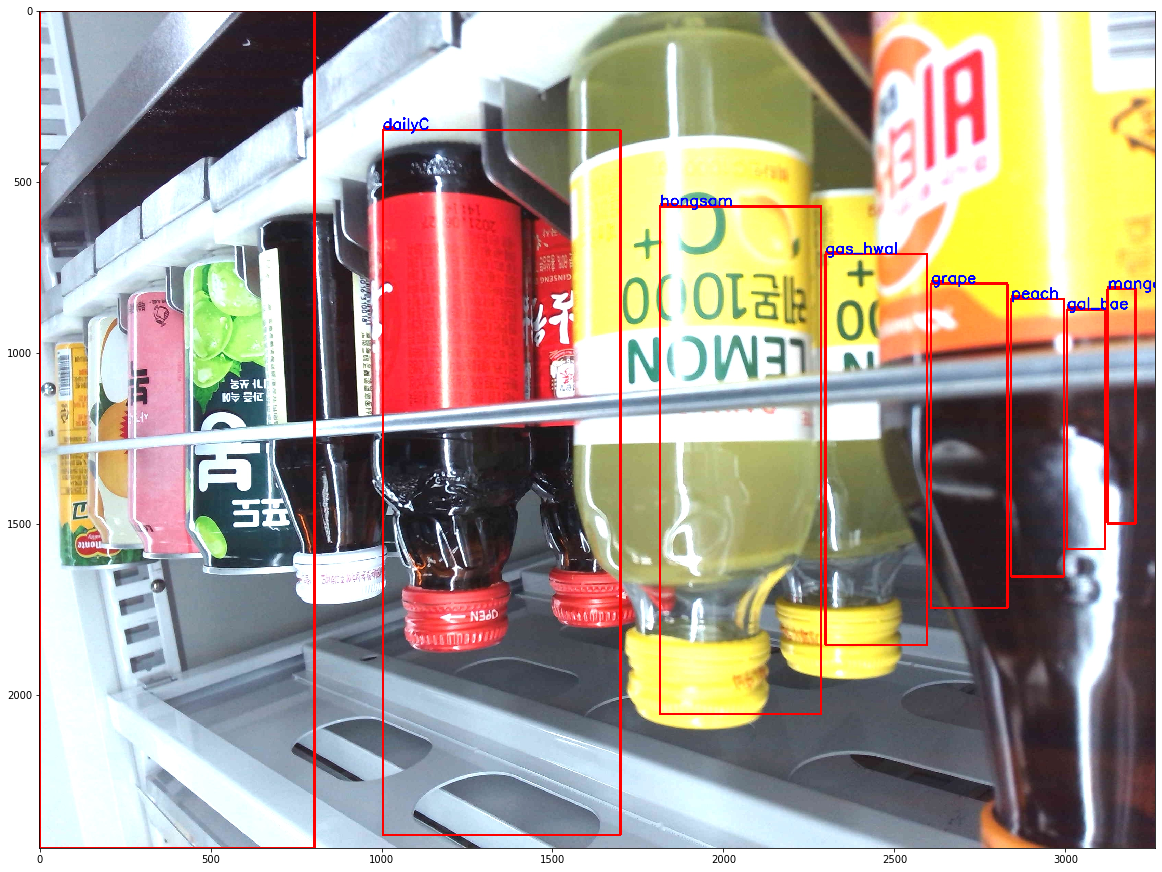

In [158]:
def get_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (0, 0, 255)


img = get_image('../datasets/od_test/image/after_usbcam(2020-03-06-10:56:40).jpg')

xml = '../datasets/od_test/image/after_usbcam(2020-03-06-10:56:40).xml'

root = minidom.parse(xml)
bnd = root.getElementsByTagName('bndbox')
class_name = root.getElementsByTagName('name')

for i in range(len(bnd_1)):
    xmin = int(bnd_1[i].childNodes[1].childNodes[0].nodeValue)
    ymin = int(bnd_1[i].childNodes[3].childNodes[0].nodeValue)
    xmax = int(bnd_1[i].childNodes[5].childNodes[0].nodeValue)
    ymax = int(bnd_1[i].childNodes[7].childNodes[0].nodeValue)

    label = class_name[i].childNodes[0].nodeValue
    
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color=BOX_COLOR, thickness=5)
    #class_name = class_idx_to_name[class_id]
    ((text_width, text_height), _) = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (xmin, ymin - int(1.3 * text_height)), (xmin + text_width, ymin), BOX_COLOR, -1)
    cv2.putText(img, label, (xmin, ymin - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 1.5,TEXT_COLOR, lineType=cv2.LINE_AA, thickness=3)
    
plt.figure(figsize=(20, 20))
plt.imshow(img)

In [75]:
def get_aug(aug, min_area=0., min_visibility=0.):
    return Compose(aug, bbox_params=BboxParams(format='pascal_voc', min_area=min_area, 
                                               min_visibility=min_visibility, label_fields=['category_id']))

In [153]:
import xml.etree.ElementTree as ET

def read_anntation(xml_file: str):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    bounding_box_list = []

    file_name = root.find('filename').text
    for obj in root.iter('object'):

        object_label = obj.find("name").text
        for box in obj.findall("bndbox"):
            x_min = int(box.find("xmin").text)
            y_min = int(box.find("ymin").text)
            x_max = int(box.find("xmax").text)
            y_max = int(box.find("ymax").text)

        bounding_box = [object_label, x_min, y_min, x_max, y_max]
        bounding_box_list.append(bounding_box)

    return bounding_box_list, file_name

In [154]:
read_anntation(xml_path)

FileNotFoundError: [Errno 2] No such file or directory: '../datasets/od_test/image/after_usbcam(2020-03-06-10:56:40).xml'

In [155]:
import os
import cv2
import numpy as np

xml_path = '../datasets/od_test/xml/'
image_path = '../datasets/od_test/image/'

def read_train_dataset(image_path):
    images = []
    annotations = []

    for file in os.listdir(image_path):
        if 'jpg' in file.lower() or 'png' in file.lower():
            images.append(cv2.imread(image_path + file, 1))
            annotation_file = xml_path + file.split('.')[0] +'.xml'
            bounding_box_list, file_name = read_anntation(annotation_file)
            annotations.append((bounding_box_list, annotation_file, file_name))

    images = np.array(images)

    return images, annotations

In [104]:
read_train_dataset(image_path)[1][1][0]

[['vita_500', 1, 1, 805, 2448],
 ['dailyC', 1005, 350, 1700, 2409],
 ['hongsam', 1816, 573, 2287, 2056],
 ['gas_hwal', 2300, 713, 2597, 1855],
 ['grape', 2609, 799, 2832, 1746],
 ['peach', 2843, 844, 2998, 1654],
 ['gal_bae', 3006, 874, 3118, 1574],
 ['mango', 3125, 815, 3207, 1499]]

In [88]:
xml_path = '../datasets/od_test/xml/'
image_path = '../datasets/od_test/image/'

xml_path + os.listdir(image_path)[0] +'.xml'

'../datasets/od_test/xml/usbcam(2020-03-06-10:56:40).jpg.xml'

BB 0: (1.0000, 4.0000, 780.0000, 2448.0000) -> (2483.0000, -1.0000, 3262.0000, 2443.0000)
BB 1: (972.0000, 340.0000, 1684.0000, 2407.0000) -> (1579.0000, 40.0000, 2291.0000, 2107.0000)
BB 2: (1801.0000, 573.0000, 2280.0000, 2066.0000) -> (983.0000, 381.0000, 1462.0000, 1874.0000)
BB 3: (2296.0000, 712.0000, 2606.0000, 1851.0000) -> (657.0000, 596.0000, 967.0000, 1735.0000)
BB 4: (2618.0000, 799.0000, 2835.0000, 1741.0000) -> (428.0000, 706.0000, 645.0000, 1648.0000)
BB 5: (2844.0000, 847.0000, 3000.0000, 1652.0000) -> (263.0000, 795.0000, 419.0000, 1600.0000)
BB 6: (3008.0000, 875.0000, 3118.0000, 1578.0000) -> (145.0000, 869.0000, 255.0000, 1572.0000)
BB 7: (3124.0000, 813.0000, 3203.0000, 1501.0000) -> (60.0000, 946.0000, 139.0000, 1634.0000)
BB 0: (1.0000, 1.0000, 805.0000, 2448.0000) -> (2458.0000, -1.0000, 3262.0000, 2446.0000)
BB 1: (1005.0000, 350.0000, 1700.0000, 2409.0000) -> (1563.0000, 38.0000, 2258.0000, 2097.0000)
BB 2: (1816.0000, 573.0000, 2287.0000, 2056.0000) -> (976.0

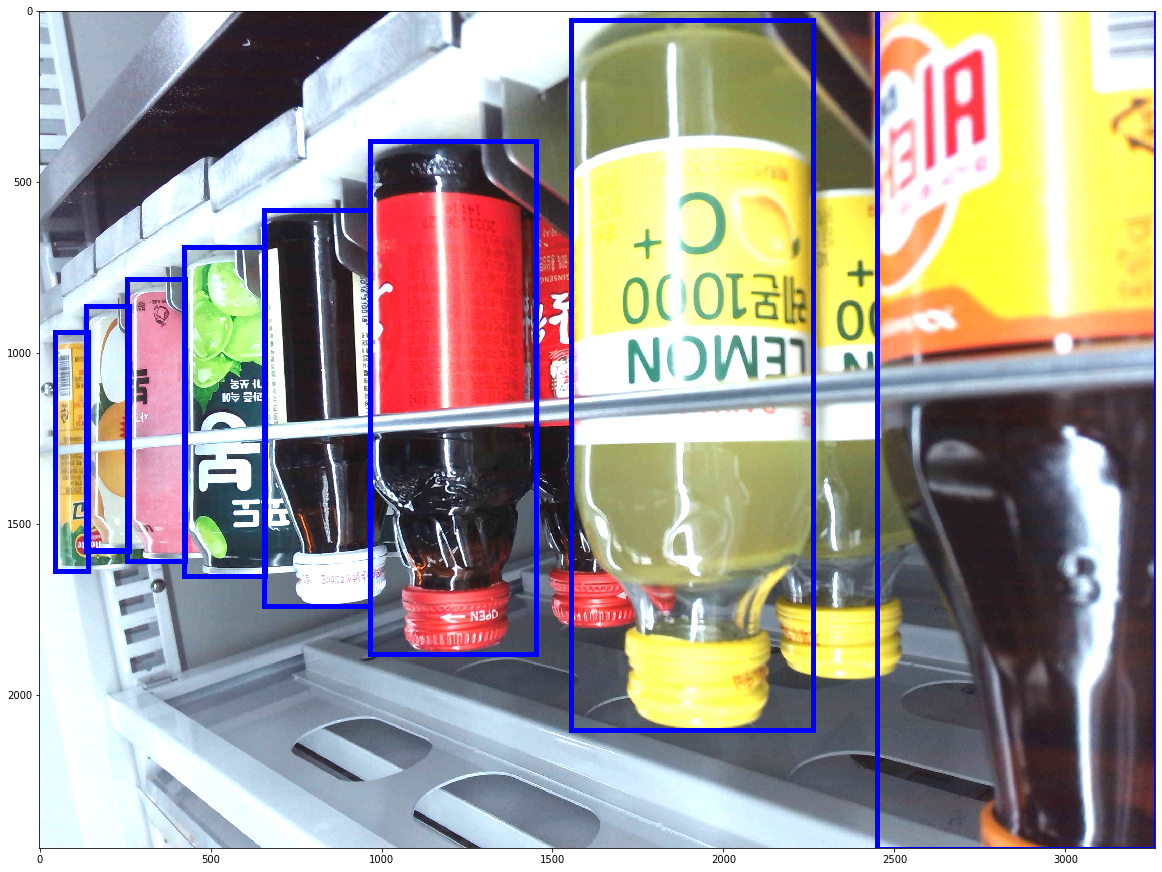

In [162]:
import imgaug as ia
from imgaug import augmenters as iaa
from files import *


np.random.bit_generator = np.random._bit_generator

ia.seed(1)

images, annotations = read_train_dataset(image_path)

for idx in range(len(images)):
    image = images[idx]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    boxes = annotations[idx][0]

    ia_bounding_boxes = []
    for box in boxes:
        ia_bounding_boxes.append(ia.BoundingBox(x1=box[1], y1=box[2], x2=box[3], y2=box[4]))
    bbs = ia.BoundingBoxesOnImage(ia_bounding_boxes, shape=image.shape)

    seq = iaa.Sequential([
            iaa.Multiply((1.2, 1.5)),
            iaa.Affine(
                #translate_px={"x": 40, "y": 60},
                #scale=(0.5, 0.7),
                rotate=180  # 이미지 회전 추가
            )
        ])

    seq_det = seq.to_deterministic()

    image_aug = seq_det.augment_images([image])[0]
    bbs_aug = seq_det.augment_bounding_boxes([bbs])[0]

    for i in range(len(bbs.bounding_boxes)):
        before = bbs.bounding_boxes[i]
        after = bbs_aug.bounding_boxes[i]
        print("BB %d: (%.4f, %.4f, %.4f, %.4f) -> (%.4f, %.4f, %.4f, %.4f)" % (
            i,
            before.x1, before.y1, before.x2, before.y2,
            after.x1, after.y1, after.x2, after.y2)
        )

    image_before = bbs.draw_on_image(image, thickness=20)
    image_after = bbs_aug.draw_on_image(image_aug, thickness=15, color=[0, 0, 255])

    #cv2.imshow('image_before', cv2.resize(image_before, (380, 640)))
    #cv2.imshow('image_after', cv2.resize(image_after, (380, 640)))

    #cv2.waitKey(0)
plt.figure(figsize=(20, 20))
plt.imshow(image_after)

In [163]:
import imgaug as ia
from imgaug import augmenters as iaa
from files import *


np.random.bit_generator = np.random._bit_generator

ia.seed(1)

images, annotations = read_train_dataset(image_path)

for idx in range(len(images)):
    image = images[idx]
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    boxes = annotations[idx][0]

    ia_bounding_boxes = []
    for box in boxes:
        ia_bounding_boxes.append(ia.BoundingBox(x1=box[1], y1=box[2], x2=box[3], y2=box[4]))
    bbs = ia.BoundingBoxesOnImage(ia_bounding_boxes, shape=image.shape)

    seq = iaa.Sequential([
               iaa.Multiply((0.5, 1.7)),
               iaa.OneOf([
                   iaa.Fliplr(0.5),
                   iaa.Affine(
                   #translate_px={"x": 40, "y": 60},
                   #scale=(0.5, 0.7),
                   rotate=180,
               )])
           ])

    seq_det = seq.to_deterministic()

    image_aug = seq_det.augment_images([image])[0]
    
    bbs_aug = seq_det.augment_bounding_boxes([bbs])[0]

    new_image_file = image_path + 'after_' + annotations[idx][2]
    cv2.imwrite(new_image_file, image_aug)

    h, w = np.shape(image_aug)[0:2]
    voc_writer = Writer(new_image_file, w, h)

    for i in range(len(bbs_aug.bounding_boxes)):
        bb_box = bbs_aug.bounding_boxes[i]
        voc_writer.addObject(boxes[i][0], int(bb_box.x1), int(bb_box.y1), int(bb_box.x2), int(bb_box.y2))

    voc_writer.save(image_path + 'after_' + annotations[idx][1].split('/')[-1])


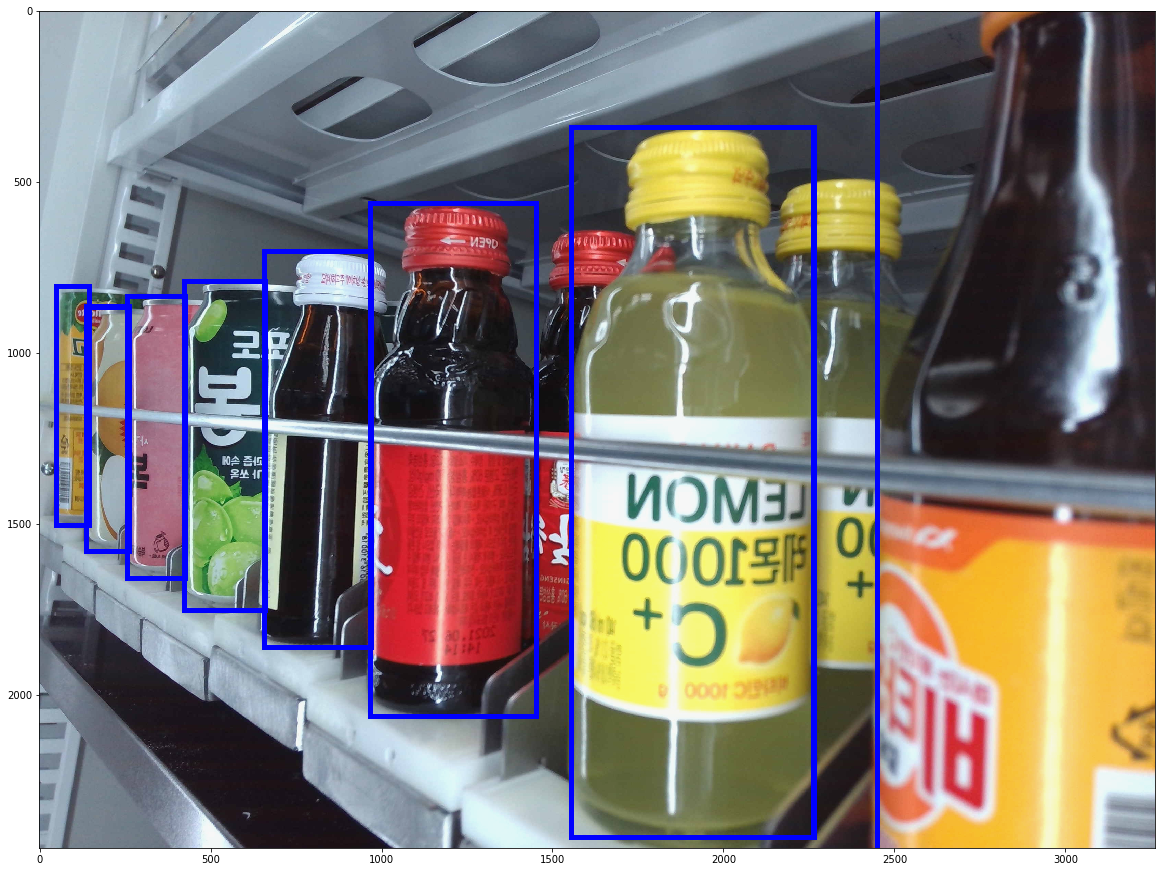

In [331]:
### Aug Test 용도

import imgaug as ia
from imgaug import augmenters as iaa
from files import *
import xml.etree.ElementTree as ET
import os
import cv2
import numpy as np


xml_path = '../datasets/od_test/xml/'
image_path = '../datasets/od_test/image/'


def read_anntation(xml_file: str):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    bounding_box_list = []

    file_name = root.find('filename').text
    for obj in root.iter('object'):

        object_label = obj.find("name").text
        for box in obj.findall("bndbox"):
            x_min = int(box.find("xmin").text)
            y_min = int(box.find("ymin").text)
            x_max = int(box.find("xmax").text)
            y_max = int(box.find("ymax").text)

        bounding_box = [object_label, x_min, y_min, x_max, y_max]
        bounding_box_list.append(bounding_box)

    return bounding_box_list, file_name


def read_train_dataset(image_path):
    images = []
    annotations = []

    for file in os.listdir(image_path):
        if 'jpg' in file.lower() or 'png' in file.lower():
            images.append(cv2.imread(image_path + file, 1))
            annotation_file = xml_path + file.split('.')[0] +'.xml'
            bounding_box_list, file_name = read_anntation(annotation_file)
            annotations.append((bounding_box_list, annotation_file, file_name))

    images = np.array(images)

    return images, annotations



np.random.bit_generator = np.random._bit_generator

ia.seed(1)

images, annotations = read_train_dataset(image_path)

for idx in range(len(images)):
    image = images[idx]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    boxes = annotations[idx][0]

    ia_bounding_boxes = []
    for box in boxes:
        ia_bounding_boxes.append(ia.BoundingBox(x1=box[1], y1=box[2], x2=box[3], y2=box[4]))
    bbs = ia.BoundingBoxesOnImage(ia_bounding_boxes, shape=image.shape)

    seq = iaa.Sequential([
                iaa.Multiply((0.5, 1.7)),
                iaa.OneOf([
                    iaa.Fliplr(1),
                    iaa.Affine(
                    #translate_px={"x": 40, "y": 60},
                    #scale=(0.5, 0.7),
                    rotate=180,

                )])
            ])

    seq_det = seq.to_deterministic()

    image_aug = seq_det.augment_images([image])[0]
    bbs_aug = seq_det.augment_bounding_boxes([bbs])[0]

    for i in range(len(bbs.bounding_boxes)):
        before = bbs.bounding_boxes[i]
        after = bbs_aug.bounding_boxes[i]
        #print("BB %d: (%.4f, %.4f, %.4f, %.4f) -> (%.4f, %.4f, %.4f, %.4f)" % (
        #    i,
        #    before.x1, before.y1, before.x2, before.y2,
        #    after.x1, after.y1, after.x2, after.y2)
        #)

    image_before = bbs.draw_on_image(image, thickness=20)
    image_after = bbs_aug.draw_on_image(image_aug, thickness=15, color=[0, 0, 255])

    #cv2.imshow('image_before', cv2.resize(image_before, (380, 640)))
    #cv2.imshow('image_after', cv2.resize(image_after, (380, 640)))

    #cv2.waitKey(0)
plt.figure(figsize=(20, 20))
plt.imshow(image_after)

In [209]:
import glob
imm = glob.glob(image_path+'*')[1]

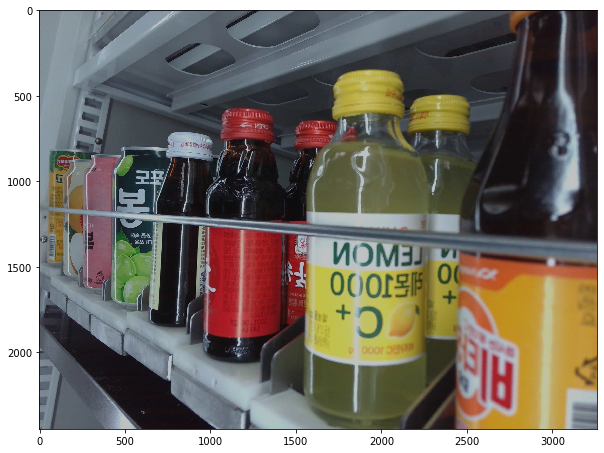

In [345]:
image = cv2.imread(imm)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
seq = iaa.Sequential([
            iaa.Multiply((0.5, 1.7)),
            iaa.OneOf([
                iaa.Fliplr(0.5),
                iaa.Affine(
                #translate_px={"x": 40, "y": 60},
                #scale=(0.5, 0.7),
                rotate=180,
                
            )])
        ])

seq_det = seq.to_deterministic()

image_aug = seq_det.augment_images([image])[0]

plt.figure(figsize=(10, 10))
plt.imshow(image_aug)

In [211]:
imm

'../datasets/od_test/image/usbcam(2020-03-06-10:56:40).jpg'

In [347]:
image_path = '../datasets/od_test/image/'

img_li = glob.glob(image_path+'*')
img_li

['../datasets/od_test/image/usbcam(2020-03-06-15:08:54).jpg',
 '../datasets/od_test/image/usbcam(2020-03-06-10:57:19).jpg',
 '../datasets/od_test/image/usbcam(2020-03-06-10:56:40).jpg',
 '../datasets/od_test/image/usbcam(2020-03-06-15:07:54).jpg',
 '../datasets/od_test/image/usbcam(2020-03-06-15:08:34).jpg']

In [349]:
import random


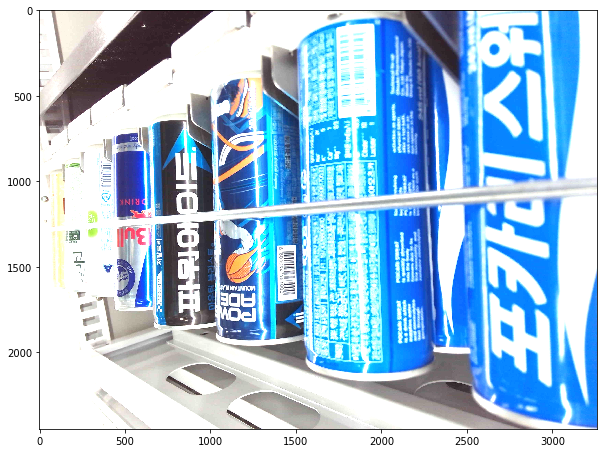

In [403]:
image_path = '../datasets/od_test/image/'

img_li = glob.glob(image_path+'*')

rand_idx = random.randint(0,len(img_li)-1)


image = cv2.imread(img_li[rand_idx])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
seq = iaa.Sequential([
            iaa.Multiply((0.5, 1.7)),
            iaa.OneOf([
                iaa.Fliplr(0.5),
                iaa.Affine(
                #translate_px={"x": 40, "y": 60},
                #scale=(0.5, 0.7),
                rotate=180,
                
            )])
        ])

seq_det = seq.to_deterministic()

image_aug = seq_det.augment_images([image])[0]

plt.figure(figsize=(10, 10))
plt.imshow(image_aug)